<H2 style="text-align: center">Reinforcement Learning</H2>

In [94]:
print(__import__('sys').version)
!conda list -n ML

3.6.7 |Anaconda, Inc.| (default, Dec 10 2018, 20:35:02) [MSC v.1915 64 bit (AMD64)]
# packages in environment at C:\Anaconda3\envs\ML:
#
# Name                    Version                   Build  Channel
backcall                  0.1.0                    py36_0  
blas                      1.0                         mkl  
ca-certificates           2019.1.23                     0  
certifi                   2018.11.29               py36_0  
colorama                  0.4.1                    py36_0  
cycler                    0.10.0           py36h009560c_0  
decorator                 4.3.0                    py36_0  
freetype                  2.9.1                ha9979f8_1  
icc_rt                    2019.0.0             h0cc432a_1  
icu                       58.2                 ha66f8fd_1  
intel-openmp              2019.1                      144  
ipykernel                 5.1.0            py36h39e3cac_0  
ipython                   7.2.0            py36h39e3cac_0  
ipython_genutils

In [1]:
%pylab
from tqdm import tqdm

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib



# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [2]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10, **kwargs):
        '''
        Generates a new Gridworld problem, with a grid of size (width, height). 
        gamma: reward discount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0, 0])
        goal: goal location (default: [0, 0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for
               walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''

        self.n_actions = 4
        self.n_states = width *  height
        self.name = kwargs.get('name', 'Grid World')
        self.actions = range(self.n_actions)
        self.states = range(self.n_states)
        self.width = width
        self.height = height
        self.gamma = gamma
        self.delta = np.array([[0, -1], [+1, 0], [0, +1], [-1, 0]])
        self.actions_labels = ['up', 'right', 'down', 'left']
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height, width))
        for c in range(width): 
            for r in range(height): 
                if [c, r] == goal: 
                    self.grid[r, c] = 1
                elif [c, r] in cliff: 
                    self.grid[r, c] = 2
                elif [c, r] == start: 
                    self.grid[r, c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = '   %s:\n' % self.name
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r, c] == 1: 
                    s += 'G'
                elif self.grid[r, c] == 2: 
                    s += 'X'
                elif self.grid[r, c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self, S): 
        '''
        Graphical display of a solution S, given as a list of states that brings
        from the initial state to the goal. 
        '''
        s = 'Solution: %s\n' % self.name
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c, r))                
                
                if self.grid[r, c] == 1: 
                    s += 'G'
                elif self.grid[r, c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r, c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print(array(self.states).reshape((self.width, self.height)).T)
    
    def encode_state(self, coord):
        '''
        Converts a tuple (c, r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c, r) = coord
        if r < self.height and c < self.width and r >= 0 and c >= 0: 
            return int(c * self.height + r)
        else: 
            return -1
    
    def decode_state(self, s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return s // self.height, s % self.height
        
    def state_action_state(self, s, a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        ns = self.encode_state(self.decode_state(s) + self.delta[a, :])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s, self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns, 0)]
        
        else: 
            return [(ns, self.penalty)]
        
    def state_transition(self, s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv, pv, rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(self.n_actions, dtype='uint')
        rv = np.zeros(self.n_actions)
        
        # cannot move away from goal
        if s == self.goal:
            return s, 0
        
        # every action on a cliff returns to start
        if s in self.cliff:
            return self.start, self.cliff_penalty
        
        for a in self.actions: 
            s2, r2 = self.state_action_state(s, a)[0]
            sv[a] = s2
            rv[a] = r2
        
        return sv, rv

## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, we will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right">

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right">

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right">

In [3]:
level1 = GridWorld(6, 4, gamma=0.9, goal=[5, 3], start=[0, 0], cliff=[], name='level 1')

level2 = GridWorld(6, 4, gamma=0.9, goal=[5, 3], start=[0, 3],
                   cliff=[[1, 3], [2, 3], [3, 3], [4, 3]], name='level 2', cliff_penalty=-100)

level3 = GridWorld(6, 4, gamma=0.9, goal=[5, 3], start=[0, 0],
                   cliff=[[1, 0], [1, 1], [1, 2],
                          [3, 3], [3, 2], [3, 1],
                          [5, 0], [5, 1], [5, 2]], name='level 3')

print(level1.tostring())
print(level2.tostring())
print(level3.tostring())

   level 1:
+-+-+-+-+-+-+
|S| | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | |G|
+-+-+-+-+-+-+

   level 2:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

   level 3:
+-+-+-+-+-+-+
|S|X| | | |X|
+-+-+-+-+-+-+
| |X| |X| |X|
+-+-+-+-+-+-+
| |X| |X| |X|
+-+-+-+-+-+-+
| | | |X| |G|
+-+-+-+-+-+-+



In [4]:
def decode_policy(env, policy, max_iter=50):
    '''
    A function to produce a path of states, from starting position to end
    position of the input environment, using the input policy. The function
    will converge to end goal if policy is valid else it will exit after max
    iterations are reached.
    
    '''
    policy = argmax(policy, axis=1)
    state = env.start
    path = [state]
    performance = 0
    
    for _ in range(max_iter):
        action = policy[state]
        state, reward = env.state_action_state(state, action)[0]
        performance += reward
        path.append(state)
        
        if state == env.goal:
            break
            
    return array(path).astype(int), performance


def policy_improvement(env, policy, V, gamma):
    policy_stable = True

    for s in env.states:
        current_action = argmax(policy[s])
        next_states, rewards = env.state_transition(s)
        action_values = rewards + gamma * V[next_states]
        next_action = argmax(action_values)

        if current_action != next_action:
            policy_stable = False

        policy[s] = eye(env.n_actions)[next_action]

    return policy, policy_stable


def policy_evaluation(env, policy, gamma=0.9, epsilon=1e-5):
    V = zeros(env.n_states)
    while 1:
        delta = 0
        for s in env.states:
            next_states, rewards = env.state_transition(s)
            v = sum(policy[s] * (rewards + gamma * V[next_states]))
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < epsilon:
            break
    return V

def policy_iteration(
                     env, 
                     policy_evaluation=policy_evaluation,
                     policy_improvement=policy_improvement, 
                     **kwargs,
                     ):
    '''
    Policy iteration as described in Reinforcement Learning: an Introduction. Richard S.
    Sutton and Andrew G. Barto, MIT press, 1998.
    
    '''

    gamma = kwargs.get('gamma', 0.90)
    policy = kwargs.get('policy', ones([env.n_states, env.n_actions]) / env.n_actions)
    max_iter = kwargs.get('max_iter', None)
    output_iter = kwargs.get('output_iter', [1, 2, 5, 10])
    
    k = 1
    
    V = zeros(env.n_states)
    
    while 1:
        
        # Evaluate the current policy
        V = policy_evaluation(env, policy, gamma)
        policy, policy_stable = policy_improvement(env, policy, V, gamma)

        if max_iter and k in output_iter:
            print('Value function for k=%d\n' % k,
                  V.reshape(env.height, env.width, order='F').round(0),
                  '\n')

        # check max iter reached or algo. converged
        if max_iter:
            if k > max_iter:
                break

            k += 1

        elif policy_stable:
            break

    return policy.astype(int)

I have implemented an in-place version of the algorithm which also assumes that each action has an equal probability and is greedy. I made some minor adjustments to the state_transition method of the GridWorld in order to return a set of states and actions if the agent finds itself in a 'cliff state' or a 'goal state'. Basically if on a cliff, every action returns to the start and if on the goal every action returns to the goal. Although, theoretically the agent shouldn't end up in these states, as the states next to a cliff return the agent to the start if the agent goes onto a cliff and the agent cannot move once on the goal, the value function makes more sense. Another way to have solved this problem would be to not iterate through the cliff states and goal state during policy iteration, but remove them from the value function basically. 

In [5]:
print('level 1 value function')
level1_policy = policy_iteration(level1, max_iter=10)
print('level 2 value function')
level2_policy = policy_iteration(level2, max_iter=10)
print('level 3 value function')
level3_policy = policy_iteration(level3, max_iter=10)

level 1 value function
Value function for k=1
 [[-10. -10. -10.  -9.  -9.  -9.]
 [-10. -10.  -9.  -9.  -8.  -8.]
 [-10. -10.  -9.  -9.  -7.  -5.]
 [-10.  -9.  -9.  -8.  -5.   0.]] 

Value function for k=2
 [[-5. -5. -4. -3. -3. -2.]
 [-5. -4. -3. -3. -2. -1.]
 [-4. -3. -3. -2. -1.  0.]
 [-3. -3. -2. -1.  0.  0.]] 

Value function for k=5
 [[-5. -5. -4. -3. -3. -2.]
 [-5. -4. -3. -3. -2. -1.]
 [-4. -3. -3. -2. -1.  0.]
 [-3. -3. -2. -1.  0.  0.]] 

Value function for k=10
 [[-5. -5. -4. -3. -3. -2.]
 [-5. -4. -3. -3. -2. -1.]
 [-4. -3. -3. -2. -1.  0.]
 [-3. -3. -2. -1.  0.  0.]] 

level 2 value function
Value function for k=1
 [[ -52.  -54.  -55.  -52.  -46.  -39.]
 [ -68.  -75.  -78.  -74.  -64.  -45.]
 [-102. -130. -136. -133. -114.  -47.]
 [-150. -235. -235. -235. -235.    0.]] 

Value function for k=2
 [[ -10.  -10.  -10.  -10.  -10.  -10.]
 [ -10.  -10.  -10.  -10.  -10.  -10.]
 [ -10.  -10.  -10.  -10.   -1.    0.]
 [ -10. -109. -109. -109. -109.    0.]] 

Value function for k=5


It can be seen that for the small, easier problems we have attempted, that the value functions converge quickly. Level 1 and 2 appear to have converged by k=5. Level 3 may or may not have fully converged by k=10 but a path can be seen.

In [6]:
level1_path = decode_policy(level1, level1_policy)[0]
print('optimum %s path:\n%s\n' % (level1.name, repr(level1_path)))
level2_path = decode_policy(level2, level2_policy)[0]
print('optimum %s path:\n%s\n' % ('level 2', repr(level2_path)))
level3_path = decode_policy(level3, level3_policy)[0]
print('optimum %s path:\n%s\n' % ('level 3', repr(level3_path)))

optimum level 1 path:
array([ 0,  4,  8, 12, 16, 20, 21, 22, 23])

optimum level 2 path:
array([ 3,  2,  6, 10, 14, 18, 22, 23])

optimum level 3 path:
array([ 0,  1,  2,  3,  7, 11, 10,  9,  8, 12, 16, 17, 18, 19, 23])



In [7]:
print(level1.print_solution(level1_path))
print(level2.print_solution(level2_path))
print(level3.print_solution(level3_path))

Solution: level 1
+-+-+-+-+-+-+
|S|*|*|*|*|*|
+-+-+-+-+-+-+
| | | | | |*|
+-+-+-+-+-+-+
| | | | | |*|
+-+-+-+-+-+-+
| | | | | |G|
+-+-+-+-+-+-+

Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

Solution: level 3
+-+-+-+-+-+-+
|S|X|*|*|*|X|
+-+-+-+-+-+-+
|*|X|*|X|*|X|
+-+-+-+-+-+-+
|*|X|*|X|*|X|
+-+-+-+-+-+-+
|*|*|*|X|*|G|
+-+-+-+-+-+-+



It can be seen above that an optimum path has been found for all 3 problems and in relatively short time. Although, this algorithm requires prior knowledge of the environment, below we will look at some algorithms that do not require full prior knowledge.

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, we will:

a. Implement the SARSA algorithm, using an $\epsilon$-greedy policy. 
<div style="text-align: right">  
    
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right">  

b. C Finally, show the solution our algorithm has reached for different values of $\epsilon$.
<div style="text-align: right">  

In [8]:
def initialize_q(n_states, n_actions, dtype='ones'):

    if dtype == 'ones':

        return ones((n_states, n_actions))

    elif dtype == 'random':

        return ranf((n_states, n_actions))

    elif dtype == 'zeros':

        return zeros((n_states, n_actions))


def policy_from_q(Q, epsilon, n_actions, s):
    '''
    Looks at the available actions in a given state and returns an action based
    upon the policy (e.g. ε-greedy) and available information on the rewards
    from the possible actions from the Q table
    
    Args:
        Q         - array-like, shape[n_states, n_actions]
        epsilon   - float, scalar over [0, 1)
        n_actions - int, number of possible actions
        s         - int, the current state of the agent
        
    Returns:
        a         - int, the action to be taken
    '''

    if rand() > epsilon:
        a = argmax(Q[s, :])
    else:
        a = randint(0, n_actions)
    return a



def sarsa(env, **kwargs):
    
    alpha = kwargs.get('alpha', 0.1)
    gamma = kwargs.get('gamma', 0.9)
    epsilon = kwargs.get('epsilon', 0.1)
    n_episodes = kwargs.get('n_episodes', 100)
    n_steps = kwargs.get('n_steps', Inf)
    dtype = kwargs.get('dtype', 'ones')
    verbose = kwargs.get('verbose', False)

    Q = initialize_q(env.n_states, env.n_actions, dtype=dtype)

    episode_rewards = []
    
    if verbose:
        episode_range = tqdm(range(n_episodes))
    else:
        episode_range = range(n_episodes)

    for episode in episode_range:
        total_reward = 0
        s = env.start
        a = policy_from_q(Q, epsilon, env.n_actions, s)
        t = 1

        while t < n_steps + 1 and s != env.goal:
            s_, r = env.state_action_state(s, a)[0]
            a_ = policy_from_q(Q, epsilon, env.n_actions, s_)
            Q[s, a] += alpha * (r + (gamma * Q[s_, a_] ) - Q[s, a])
            total_reward += r
            s, a = s_, a_
            t += 1
            
        episode_rewards.append(total_reward)

    return Q, episode_rewards

In [9]:
def display_performance(n_episodes, performance, epsilons):
    '''
    just to plot some things
    
    '''
    figure(figsize=(10, 10))
    style.use('seaborn')
    
    for score, e, c in zip(performance, epsilons, ['m', 'c', 'b']):
        plot(range(1, n_episodes + 1), score, c=c, alpha=0.7, label='$ε=%.0e$' % e)
    xlabel('n_episodes', fontsize=14)
    ylabel('reward', fontsize=14)
    legend()
    show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.40s/it]


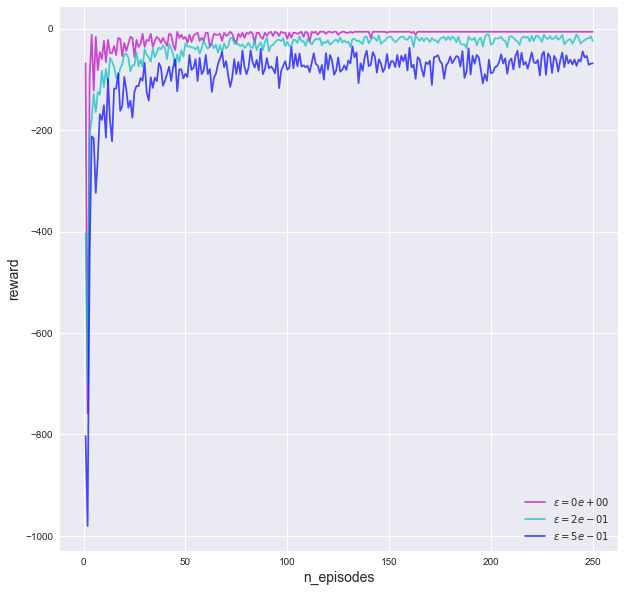

In [10]:
def performance_experiment(rl_algorithm, n_episodes, n_repetitions, epsilons, env):
    
    '''
    Run an algorithm for multiple epsilon values. The algorithm is run n_repititions
    times for each epsilon value in order to remove some of the noise 
    associated with the stocastic element of the alorithm.
    
    '''

    performance = zeros((len(epsilons), n_episodes, n_repetitions)) # 3d array
    for i in tqdm(range(len(epsilons))):
        for j in range(n_repetitions):
            performance[i, :, j] = rl_algorithm(env,
                                                n_episodes=n_episodes,
                                                epsilon=epsilons[i])[1]
    performance = mean(performance, axis=2)  
    display_performance(n_episodes, performance, epsilons)
performance_experiment(sarsa, 250, 30, [0, 0.2, 0.5], level2)

I performend 30 repetitions and averaged as this takes out some of the noise. There are 3 different values of epsilon which show that for this problem a greedy strategy produces better performance. The more exploration allowed the algorithm seems to converge on a less then optimum solution.

In [14]:
Q = sarsa(level2, n_steps=Inf, n_episodes=10000, epsilon=0.5, verbose=True)[0]

level2_path = decode_policy(level2, Q)[0]
print(level2.print_solution(level2_path))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1621.86it/s]


Solution: level 2
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|*| | | | |*|
+-+-+-+-+-+-+
|*| | | | |*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



In [19]:
Q = sarsa(level2, n_steps=Inf, n_episodes=10000, epsilon=0.1, verbose=True)[0]

level2_path = decode_policy(level2, Q)[0]
print(level2.print_solution(level2_path))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4120.62it/s]


Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*| |
+-+-+-+-+-+-+
|*| | | |*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



It can be seen that sarsa converges to a path which avoids being adjacent to the cliffs when some exploration is allowed.


In [20]:
Q = sarsa(level2, n_steps=Inf, n_episodes=10000, epsilon=0.0, verbose=True)[0]

level2_path = decode_policy(level2, Q)[0]
print(level2.print_solution(level2_path))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6312.10it/s]


Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



Although, using a greedy strategy it seems to converge to the shortest/optimum route. 

The more exploration is allowed the 'safer' the resulting solution is.

The more greedy the algorithm is the faster it seems to converge.

## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, we will:

a. implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right">

b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right">

c. Finally, show the solution our algorithm has reached for different values of $\epsilon$.
<div style="text-align: right">


Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of our own) and discuss the results. 
<div style="text-align: right">

In [21]:
def q_learning(env, **kwargs):

    alpha = kwargs.get('alpha', 0.2)
    gamma = kwargs.get('gamma', 0.9)
    epsilon = kwargs.get('epsilon', 0.1)
    n_episodes = kwargs.get('n_episodes', 100)
    n_steps = kwargs.get('n_steps', Inf)
    dtype = kwargs.get('dtype', 'ones')
    verbose = kwargs.get('verbose', False)

    Q = initialize_q(env.n_states, env.n_actions, dtype=dtype)

    episode_rewards = []
    
    if verbose:
        episode_range = tqdm(range(n_episodes))
    else:
        episode_range = range(n_episodes)

    for episode in episode_range:
        total_reward = 0
        s = env.start
        a = policy_from_q(Q, epsilon, env.n_actions, s)
        t = 1

        while t < n_steps + 1 and s != env.goal:
            s_, r = env.state_action_state(s, a)[0]
            Q[s, a] += alpha * (r + gamma * max(Q[s_]) - Q[s, a])
            total_reward += r
            s, a = s_, policy_from_q(Q, epsilon, env.n_actions, s_)
            t += 1
            
        episode_rewards.append(total_reward)

    return Q, episode_rewards

In [22]:
Q = q_learning(level2, n_steps=Inf, n_episodes=1000, epsilon=0.5)[0]

level2_path = decode_policy(level2, Q)[0]
print('ε = 0.5\n%s' % level2.print_solution(level2_path))

ε = 0.5
Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



In [23]:
Q = q_learning(level2, n_steps=Inf, n_episodes=200, epsilon=0.25)[0]

level2_path = decode_policy(level2, Q)[0]
print('ε = 0.25\n%s' % level2.print_solution(level2_path))

ε = 0.25
Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



In [24]:
Q = q_learning(level2, n_steps=Inf, n_episodes=200, epsilon=0)[0]

level2_path = decode_policy(level2, Q)[0]
print('ε = 0\n%s' % level2.print_solution(level2_path))

ε = 0
Solution: level 2
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|*|*|*|*|*|*|
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+



The q-learning algorithms seems to converge on the optimum/shortest route more often and for higher values of epsilon. It also seems to converge more rapidly.

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  2.96s/it]


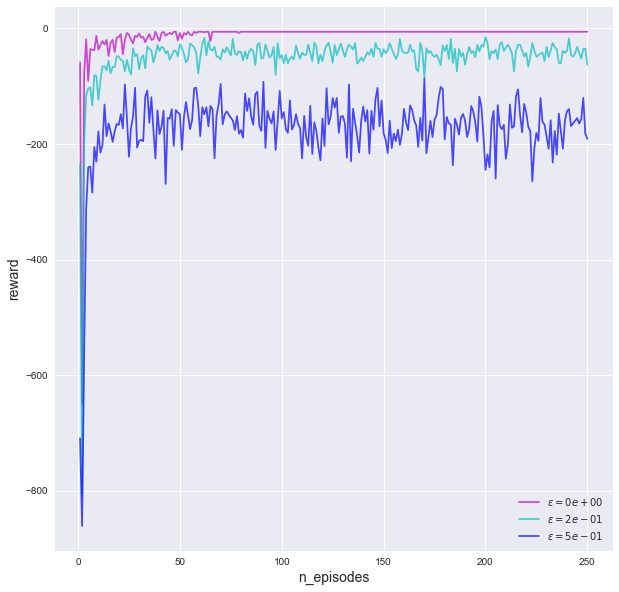

In [25]:
performance_experiment(q_learning, 250, 30, [0, 0.2, 0.5], level2)

Comparing the above figure to that of sarsa, it can be seens that the Q learning algorithm achieves a lower reward when exploration is allowed, when epsilon is greater than zero.

In [26]:
world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[2,0], [2,1], [2,2], [2,3], [2,4], [2,5], [6,5], [6,6], [6,7],[6,8],[6,9]])
print(world1.tostring())

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world2 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=cliff)
print(world2.tostring())

   Grid World:
+-+-+-+-+-+-+-+-+-+-+
|S| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |X| | | |X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |G|
+-+-+-+-+-+-+-+-+-+-+

   Grid World:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



In [30]:
Q = sarsa(world1, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


world1_solution = decode_policy(world1, Q)[0]
print(world1.print_solution(world1_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2502.75it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*| | |*|*| |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|*|*| |*|*| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| |*|*|*| | |X| |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |G|
+-+-+-+-+-+-+-+-+-+-+



In [37]:
Q = sarsa(world1, n_steps=Inf, n_episodes=10000, epsilon=0, alpha=0.1, verbose=True)[0]


world1_solution = decode_policy(world1, Q)[0]
print(world1.print_solution(world1_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3734.78it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| |*|X|*| | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| |*|*|*| | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |G|
+-+-+-+-+-+-+-+-+-+-+



In [32]:
Q = q_learning(world1, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


world1_solution = decode_policy(world1, Q)[0]
print(world1.print_solution(world1_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2700.18it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S|*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|X|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| |*|X|*| | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| |*|*|*| | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |G|
+-+-+-+-+-+-+-+-+-+-+



In [35]:
Q = sarsa(world2, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


world2_solution = decode_policy(world2, Q)[0]
print(world2.print_solution(world2_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4142.19it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*|*| |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| |*| |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
| |*|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*|*|G|
+-+-+-+-+-+-+-+-+-+-+



In [38]:
Q = sarsa(world2, n_steps=Inf, n_episodes=10000, epsilon=0, alpha=0.1, verbose=True)[0]


world2_solution = decode_policy(world2, Q)[0]
print(world2.print_solution(world2_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4510.73it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



In [36]:
Q = q_learning(world2, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


world2_solution = decode_policy(world2, Q)[0]
print(world2.print_solution(world2_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3342.89it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+



It can be seen that, with more exploration allowed, sarsa will converge to a 'safer' route which may also be a longer route. Q learning seems to always converge to the shortest route. If we use sarsa with a low value of epsilon, with minimal exploration, it behaves like q learning and returns the shortest route.

In [23]:
from itertools import cycle

centre = array([4, 3])

cliffs = [centre.tolist()]

up, right, down, left = level1.delta

spiral = cycle([up, right, down, left])

for i in range(8):
    spiral_arm = spiral.__next__()
    for j in range(i):
        centre += spiral_arm
        cliffs.append(centre.tolist())

level4 = GridWorld(9, 9, gamma=0.9, start=[4, 4], goal=[0, 0], 
                   cliff=cliffs, name='level4')


print(level4.tostring())

   level4:
+-+-+-+-+-+-+-+-+-+
|G| | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | |X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| | |X| | | | |X| |
+-+-+-+-+-+-+-+-+-+
| | |X| |X|X| |X| |
+-+-+-+-+-+-+-+-+-+
| | |X| |S|X| |X| |
+-+-+-+-+-+-+-+-+-+
| | |X|X|X|X| |X| |
+-+-+-+-+-+-+-+-+-+
| | | | | | | |X| |
+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



In [24]:
Q = sarsa(level4, n_steps=Inf, n_episodes=10000, epsilon=0.0, alpha=0.1, verbose=True)[0]

level4_solution = decode_policy(level4, Q)[0]
print(level4.print_solution(level4_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1837.94it/s]


Solution: level4
+-+-+-+-+-+-+-+-+-+
|G|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+
| |*|X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|*|*|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|X|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|S|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|X|X|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|*|*|*|*|*|X| |
+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



In [25]:
Q = q_learning(level4, n_steps=Inf, n_episodes=10000, epsilon=0.2, alpha=0.1, verbose=True)[0]

level4_solution = decode_policy(level4, Q)[0]
print(level4.print_solution(level4_solution))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 512.50it/s]


Solution: level4
+-+-+-+-+-+-+-+-+-+
|G|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+
| |*|X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|*|*|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|X|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|*|S|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|X|X|X|X|*|X| |
+-+-+-+-+-+-+-+-+-+
| |*|*|*|*|*|*|X| |
+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X|X|X| |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



Both algorithms take much longer to find the goal when they are surrounded by cliffs.

In [45]:
level5 = GridWorld(13, 13, gamma=0.9, start=[0, 0], goal=[12, 4], 
                   cliff=[[6, 0], [8, 1], [8, 2], [6, 2], [6, 3],
                          [6, 4], [6, 5], [6, 6], [6, 7], [6, 8]])

print(level5.tostring())

   Grid World:
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| |X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | |G|
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+



In [69]:
Q = sarsa(level5, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


level5_solution = decode_policy(level5, Q)[0]
print(level5.print_solution(level5_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1105.69it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S| | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | |X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*| | | | | |X| |X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*|*| | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |*|*| | | |X| | | | | |G|
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | |*|*| | |X| | | |*|*|*|
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*| | |X| | | |*| | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*| | |X| | | |*| | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*| | |X| | | |*| | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*| | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+



In [68]:
Q = q_learning(level5, n_steps=Inf, n_episodes=10000, epsilon=0.1, alpha=0.1, verbose=True)[0]


level5_solution = decode_policy(level5, Q)[0]
print(level5.print_solution(level5_solution))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1464.19it/s]


Solution: Grid World
+-+-+-+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*|X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X|*|X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X|*|*|*|*|*|*|
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | |G|
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+



The additional test problem support the earlier conclusion.

When considering sarsa and Q learning with non-zero epsilon, it can be said that sarsa is more likely to achieve a higher reward as it tends towards a safer route. Therefore, there is less chance for it to fall down a cliff during exploration than Q learning.